# Tutorial 7
Application of moving-average and signular spectrum analysis on synthetic data

In [1]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
#create x1 and x2 as a superposition of synthetic signals
k = 2 * np.pi / 50
omega = [2*np.pi/150, 2*np.pi/75, 2*np.pi/20] # = [0.0419, 0.0838, 0.3142]

x = [float(kk) for kk in range(100)]
t = [float(kk) for kk in range(300)]
x = np.asarray(x).reshape(-1,1)
t = np.asarray(t).reshape(-1,1)

y0 = [0.5*np.sin(k*x[0] - omega[0]*tjj) for tjj in t]
y1 = [1.0*np.sin(k*x[16] - omega[1]*tjj) for tjj in t]
y2 = [2.0*np.sin(k*x[69] - omega[2]*tjj) for tjj in t]
y3 = [0.01*tjj for tjj in t]

#x1 is sum of these 4 signals
x1 = [y0[kk]+y1[kk]+y2[kk]+y3[kk] for kk in range(len(y0))]

#x2 is x1 with a linear trend removed
lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(t,x1)
ypred_MLR = lm_MLR.predict(np.asarray(t).reshape(-1,1)) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
x2 = x1 - ypred_MLR

x1 = np.squeeze(np.asarray(x1))
x2 = np.squeeze(np.asarray(x2))

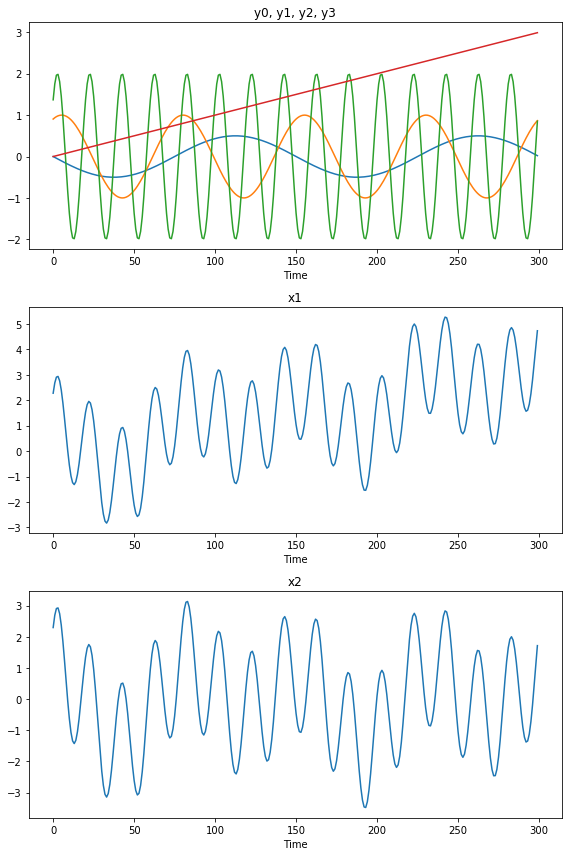

In [3]:
#visualize

plt.figure(figsize=(8,12))

plt.subplot(311)
plt.plot(y0)
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.title('y0, y1, y2, y3')
plt.xlabel('Time')

plt.subplot(312)
plt.plot(x1)
plt.title('x1')
plt.xlabel('Time')

plt.subplot(313)
plt.plot(x2)
plt.title('x2')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

## Example 1: Running mean (moving average)

In [4]:
#want frequencies from FSA to help guide window size
x2fft = np.fft.fft(x2)
Sx2 = np.abs(np.square(x2fft))
freq2 = np.fft.fftfreq(np.arange(len(x2fft)).shape[-1]) #frequency
omeg = freq2[[2,4,15,16]]

In [5]:
#calculate window sizes for the moving average 
window0 = int(1/omeg[0])+5
window1 = int(1/omeg[1])+2
window2 = int(1/np.mean(omeg[2:]))+1

In [6]:
#start by applying the smallest window (window2)
#in other words, remove the high-frequency signal
#NOTE: I've found the easiest way to do this is in pandas; or, you can define your own running mean function in numpy

x2_df = pd.Series(x2) #dataframe (df) of x2
x2_rolling2 = x2_df.rolling(window2,center=True).mean()

#now filter out the next highest frequency signal with window1 
x2_rolling1 = x2_rolling2.rolling(window1,center=True).mean()

#now filter out the next highest frequency signal with window2
x2_rolling0 = x2_rolling1.rolling(window0,center=True).mean()


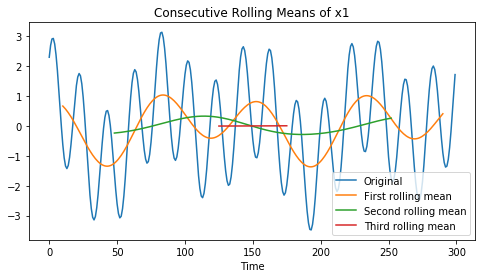

In [7]:
#visualize results

plt.figure(figsize=(8,4))
plt.plot(x2_df)
plt.plot(x2_rolling2)
plt.plot(x2_rolling1)
plt.plot(x2_rolling0)
plt.legend(('Original','First rolling mean','Second rolling mean','Third rolling mean'))
plt.title('Consecutive Rolling Means of x1')
plt.xlabel('Time')

plt.show()


## Example 2: SSA

In [8]:
#create lagged copies of the time series

x = x2 #choose time series to perform SSA on -- change to x1 or x2 and see how results compare

L = 151
n = np.size(x)

x_lag = np.zeros((L,n-L+1))
for kk in range(L):
    x_lag[kk] = x[kk:n-L+kk+1]

In [9]:
#do PCA on the lagged matrix

n_modes = np.min(np.shape(x_lag))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(x_lag)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

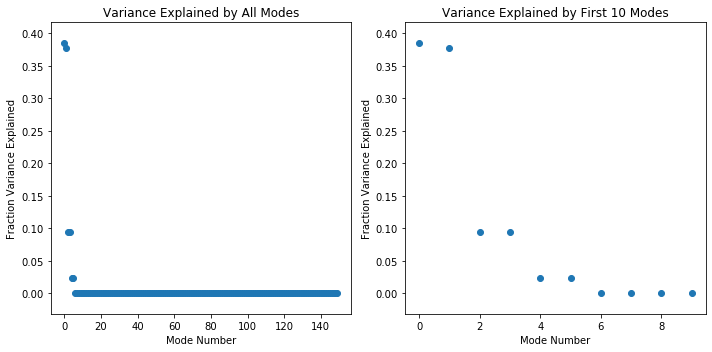

In [10]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

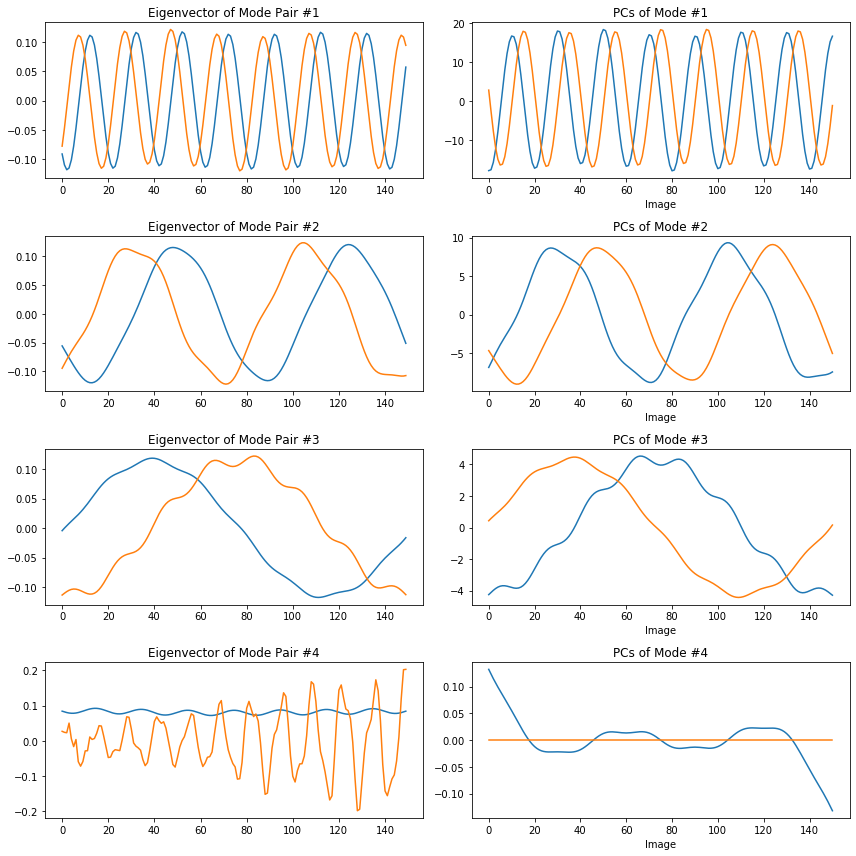

In [14]:
#plot the first n pairs of modes and PCs

n = 4

plt.figure(figsize=(12,3*n))
for kk in range(n):
    
    mode1 = 2*kk
    mode2 = 2*kk + 1
    
    plt.subplot(n,2,kk*2+1)
    plt.plot(eigvecs[mode1,:])
    plt.plot(eigvecs[mode2,:])
    plt.title('Eigenvector of Mode Pair #' + str(kk+1))
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,mode1])
    plt.plot(PCs[:,mode2])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Image')
    
    plt.tight_layout()